In [2161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D
%matplotlib inline

In [2162]:
 df = pd.read_csv('Placement_Data_Full_Class.csv')

In [2163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


In [2164]:
df.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [2165]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [2166]:
df.shape

(215, 15)

In [ ]:
df['ssc_b'].unique()

array(['Others', 'Central'], dtype=object)

In [ ]:
df['hsc_s'].unique()

array(['Commerce', 'Science', 'Arts'], dtype=object)

In [ ]:
df['degree_t'].unique()

array(['Sci&Tech', 'Comm&Mgmt', 'Others'], dtype=object)

In [ ]:
df['workex'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
df['specialisation'].unique()

array(['Mkt&HR', 'Mkt&Fin'], dtype=object)

In [2172]:
df.drop(['sl_no','salary'],axis=1,inplace=True)
#df.drop(['sl_no','salary','hsc_b','ssc_b','hsc_s'],axis=1,inplace=True)

In [2173]:
cat_feats = df.select_dtypes(exclude=[np.number]).columns

In [2174]:
cat_feats

Index(['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex',
       'specialisation', 'status'],
      dtype='object')

In [2175]:
dataset= pd.get_dummies(df,columns=cat_feats,drop_first=True)

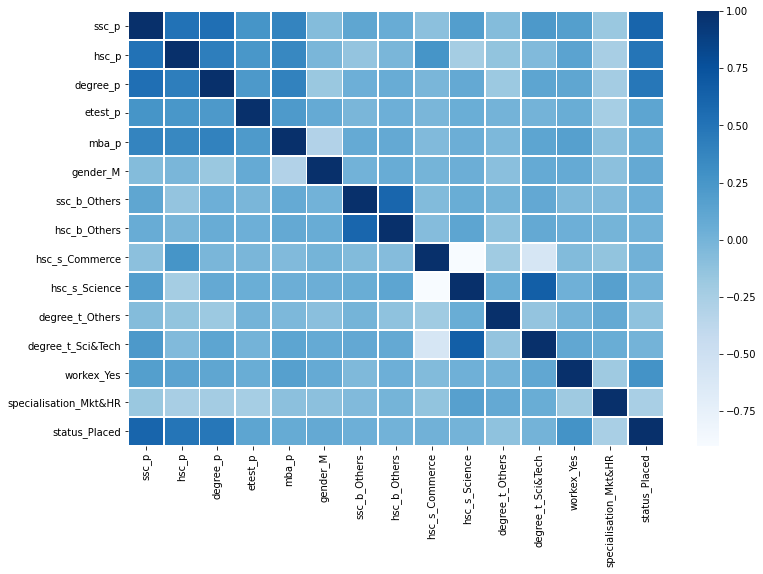

In [2176]:
corr = dataset.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr,cmap='Blues',lw=0.5)

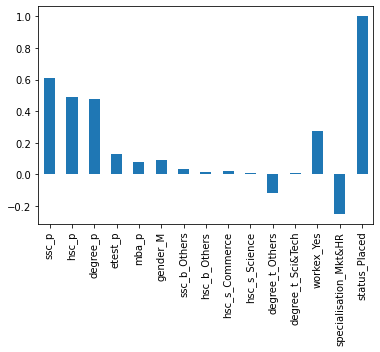

In [2177]:
corr['status_Placed'].plot(kind="bar")

In [2178]:
dataset.shape

(215, 15)

In [2179]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [2180]:
#Univariate Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2181]:
ordered_rank_features = SelectKBest(score_func=chi2,k=14)
ordered_features = ordered_rank_features.fit(X,y)

In [2188]:
df_score=pd.DataFrame(ordered_features.scores_,columns=["Score"])
df_column=pd.DataFrame(dataset.columns[:-1])
features_rank = pd.concat([df_score,df_column],axis=1)

In [2190]:
features_rank.columns=['Score','features']
features_rank

,Score,features
0,137.739258,ssc_p
1,92.449312,hsc_p
2,40.204896,degree_p
3,8.522679,etest_p
4,0.691857,mba_p
5,0.624805,gender_M
6,0.161359,ssc_b_Others
7,0.024118,hsc_b_Others
8,0.060795,hsc_s_Commerce
9,0.006571,hsc_s_Science


In [2191]:
features_rank.nlargest(10,'Score')

,Score,features
0,137.739258,ssc_p
1,92.449312,hsc_p
2,40.204896,degree_p
12,10.745484,workex_Yes
3,8.522679,etest_p
13,7.539357,specialisation_Mkt&HR
10,2.803632,degree_t_Others
4,0.691857,mba_p
5,0.624805,gender_M
6,0.161359,ssc_b_Others


In [2192]:
#Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [2193]:
print(model.feature_importances_)

[0.23135457 0.15748748 0.15507455 0.07848076 0.08991346 0.04093464
 0.03353628 0.02788723 0.0206679  0.01886994 0.01524123 0.02663972
 0.0576903  0.04622194]


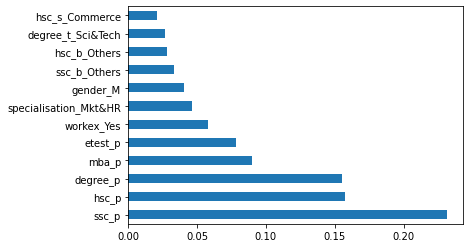

In [2195]:
ranked_features=pd.Series(model.feature_importances_,index=dataset.columns[:-1])
ranked_features.nlargest(12).plot(kind='barh')
plt.show()

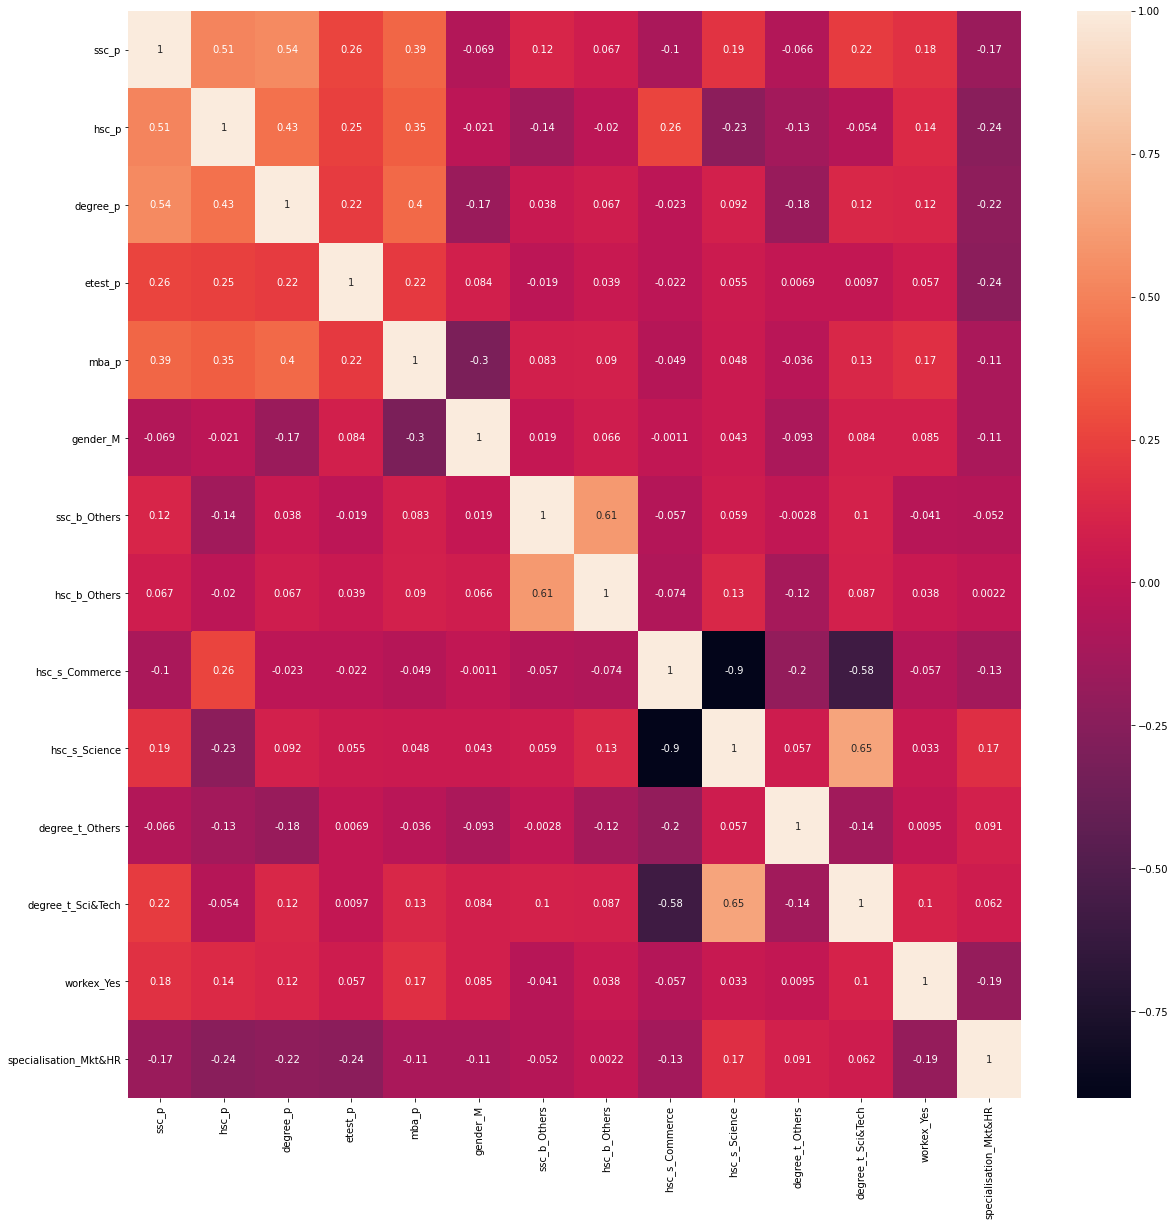

In [2204]:
#correaltion
corr = dataset.iloc[:,:-1].corr()
top_features=corr.index
plt.figure(figsize=(20,20))
sns.heatmap(dataset[top_features].corr(),annot=True)


In [2218]:
threshold=0.9

In [2205]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [2219]:
correlation(dataset.iloc[:,:-1],threshold)

{'hsc_s_Science'}

In [ ]:
print ('TOP 5 important features which impact the placements:\n',corr['status_Placed'].sort_values(ascending=False)[1:], '\n')

KeyError: ignored

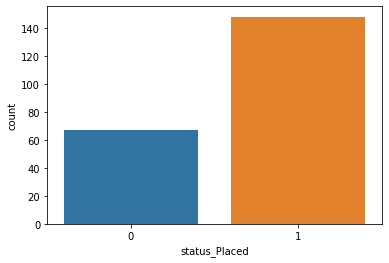

In [ ]:
sns.countplot(dataset['status_Placed'])

In [ ]:
labels=dataset.columns[:-1]
labels

Index(['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'gender_M',
       'degree_t_Others', 'degree_t_Sci&Tech', 'workex_Yes',
       'specialisation_Mkt&HR'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


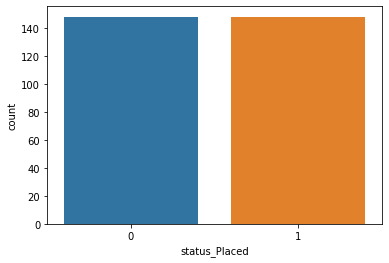

In [ ]:
smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(dataset[labels], dataset['status_Placed'])

dataset = pd.DataFrame(X_sm, columns=labels)
dataset['status_Placed'] = y_sm

sns.countplot(dataset['status_Placed'])

In [ ]:
dataset

,ssc_p,hsc_p,degree_p,etest_p,mba_p,gender_M,degree_t_Others,degree_t_Sci&Tech,workex_Yes,specialisation_Mkt&HR,status_Placed
0,67.000000,91.000000,58.000000,55.000000,58.800000,1.0,0.000000,1.000000,0.000000,1.000000,1
1,79.330000,78.330000,77.480000,86.500000,66.280000,1.0,0.000000,1.000000,1.000000,0.000000,1
2,65.000000,68.000000,64.000000,75.000000,57.800000,1.0,0.000000,0.000000,0.000000,0.000000,1
3,56.000000,52.000000,52.000000,66.000000,59.430000,1.0,0.000000,1.000000,0.000000,1.000000,0
4,85.800000,73.600000,73.300000,96.800000,55.500000,1.0,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
291,52.505397,54.265572,50.817406,74.842364,64.556956,0.0,0.000000,0.128626,0.871374,0.128626,0
292,60.569909,49.383485,55.958712,75.404129,57.414989,1.0,0.595871,0.000000,0.000000,1.000000,0
293,52.000000,50.269572,60.746602,59.946086,58.855348,1.0,0.000000,0.000000,0.000000,0.000000,0
294,56.450223,50.451469,57.072146,57.543606,61.816295,1.0,0.000000,0.000000,0.000000,0.862867,0


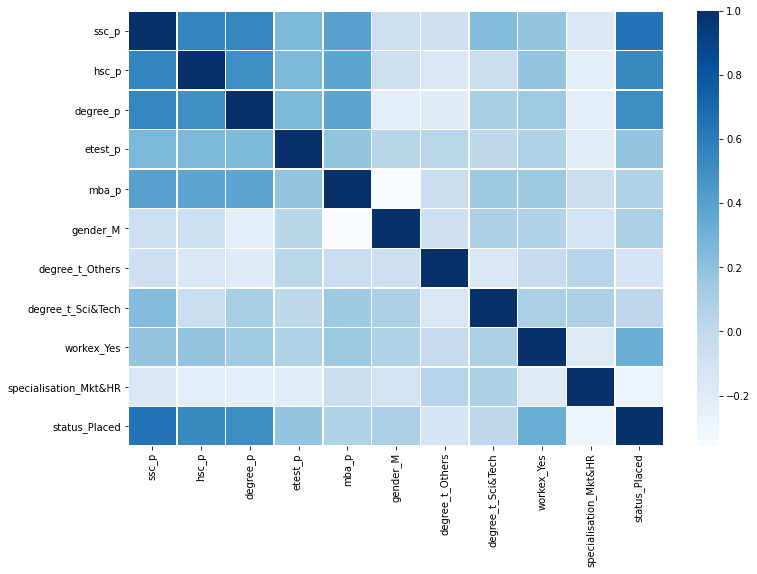

In [ ]:
corr = dataset.corr()


In [ ]:

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
print(sc.mean_)
a = sc.mean_
b = a.tolist()
print(b)

[6.50624176e+01 6.39457821e+01 6.51712321e+01 7.11869763e+01
 6.22426257e+01 6.20932842e-01 6.31238627e-02 2.59694073e-01
 2.95915895e-01 4.70969511e-01]
[65.06241757870305, 63.945782073372726, 65.17123207320799, 71.18697625411792, 62.24262568008868, 0.6209328424285236, 0.06312386273820458, 0.259694072529648, 0.29591589546182756, 0.47096951055920416]


In [ ]:
print(sc.var_)

[1.25048646e+02 1.15849428e+02 5.45738909e+01 1.51918881e+02
 3.44628085e+01 2.22280369e-01 4.99078813e-02 1.79956802e-01
 1.94197266e-01 2.30356312e-01]


In [ ]:
print(sc.scale_)
a = sc.scale_
b = a.tolist()
print(b)

[11.18251519 10.76333722  7.38741435 12.32553775  5.87050326  0.47146619
  0.22340072  0.42421316  0.44067819  0.47995449]
[11.182515186539758, 10.763337217557854, 7.3874143549037345, 12.325537745733184, 5.870503259378299, 0.471466190249285, 0.223400719030457, 0.4242131557416943, 0.44067818921818, 0.47995448975197225]


In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(Dropout(0.3))

In [ ]:
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann.add(Dropout(0.3))

In [ ]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
ann.compile(optimizer = Adam(learning_rate=0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [ ]:
ann.fit(X_train, y_train, batch_size = 10,validation_data = (X_test,y_test), epochs = 200,callbacks=[early_stop])

Epoch 1/200
24/24 [==============================] - 0s 6ms/step - loss: 0.7199 - accuracy: 0.5212 - val_loss: 0.5934 - val_accuracy: 0.7333
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5495 - accuracy: 0.7331 - val_loss: 0.4829 - val_accuracy: 0.8167
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.7966 - val_loss: 0.4216 - val_accuracy: 0.7167
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4026 - accuracy: 0.8051 - val_loss: 0.3698 - val_accuracy: 0.8000
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3477 - accuracy: 0.8136 - val_loss: 0.3471 - val_accuracy: 0.8000
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3172 - accuracy: 0.8517 - val_loss: 0.2976 - val_accuracy: 0.9000
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3247 - accuracy: 0.8517 - val_loss: 0.3273 - val_accuracy: 0.8667
Epoch 8/200
2

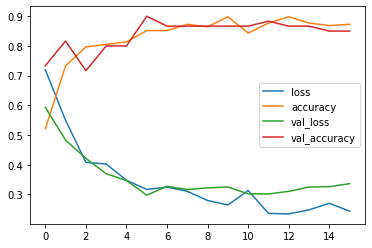

In [ ]:
loss = pd.DataFrame(ann.history.history)
loss.plot()


In [ ]:
#np.round(ann.predict(sc.transform([[67.000000,	91.000000,	58.000000,	55.000000,	58.800000,	1.000000,	1.0,	1.000000,	1.000000,	0.000000,	0.0,	1.000000,	0.000000,	1.000000]])))

In [ ]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))

[[28  5]
 [ 4 23]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.82      0.85      0.84        27

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C= 0.5, penalty= 'l2', solver= 'lbfgs')
classifier.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[32  1]
 [ 3 24]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        33
           1       0.96      0.89      0.92        27

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 87.30 %
Standard Deviation: 6.29 %


In [ ]:
parameters = [{'C': [0.01,0.25, 0.5, 0.75, 1,10],'penalty': ['l2','none'],
               'solver':['lbfgs']},
              {'C': [0.01,0.25, 0.5, 0.75, 1,10],'penalty': ['l1'],
               'solver':['liblinear']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and

Best Accuracy: 87.83 %
Best Parameters: {'C': 0.25, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and

In [ ]:
classifier.coef_.shape

(1, 10)

In [ ]:
dataset.columns[:-1].shape

(10,)

In [ ]:
coeffecients = pd.DataFrame(classifier.coef_.reshape((10,1)),dataset.columns[:-1])
coeffecients.columns = ['Coeffecient']
coeffecients.sort_values('Coeffecient',ascending=False)

,Coeffecient
ssc_p,1.970537
degree_p,1.059515
workex_Yes,0.870997
hsc_p,0.711197
gender_M,0.419413
etest_p,0.016793
degree_t_Others,-0.001909
specialisation_Mkt&HR,-0.215403
degree_t_Sci&Tech,-0.525984
mba_p,-0.828515


In [ ]:
classifier.intercept_

array([0.27535058])

# **Random Forest Classification**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion = 'entropy')
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[31  2]
 [ 5 22]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        33
           1       0.92      0.81      0.86        27

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 88.15 %
Standard Deviation: 3.90 %


from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

# **Conclusion**




Since the dataset is small, the there is a noticeable change in accuracy of the algorithms everytime we run the program.
In such a such case it is better to run all the algorithms considerable no.of.times (say 10 times) and find the mean accuracy of all the models.
Also cosider the accuracy range while choosing the best fit algorithm for your dataset. 

In my program i found Logistic regression and Kernel SVM classification as a best model to this dataset.
